# Required Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
#Read data from csv
df = pd.read_csv("solid_liquid_food.csv")
#Drop columns missing more than 85% values
df.dropna(thresh=df.shape[0]*0.85, axis=1, inplace=True)
#Remove commas in numbers
df.replace(',','', regex=True, inplace=True)

# Exploratory Data Analysis
## Missing Entries

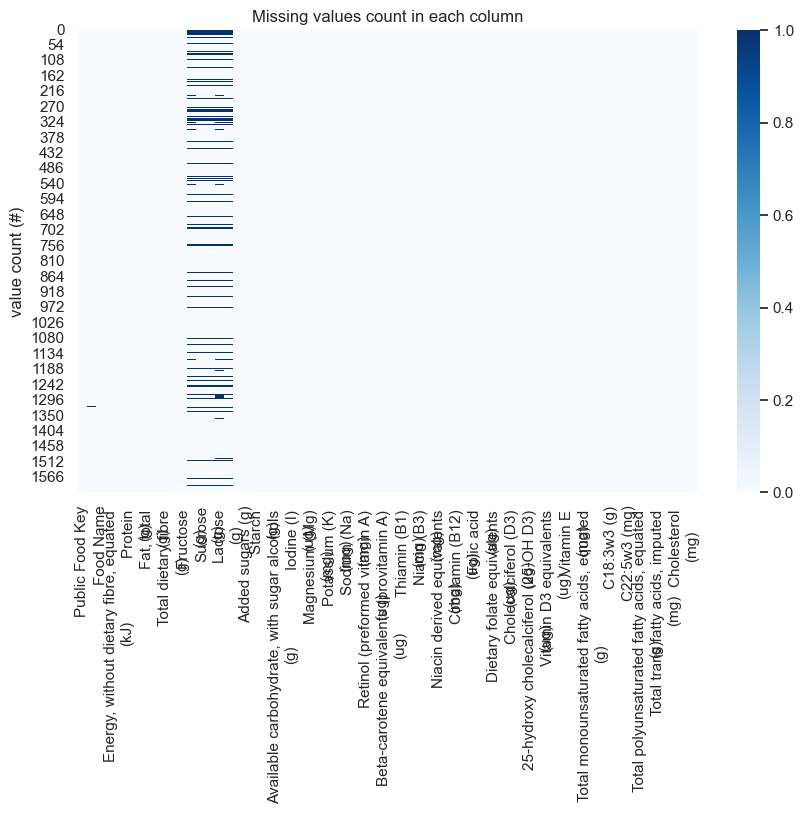

In [3]:
#Creating a heat map to see which columns have missing points
plt.figure(figsize=(10,6),dpi=100)
sns.set_theme(style='whitegrid')
sns.heatmap(df.isnull(), cmap='Blues');
#Label the map
plt.ylabel('value count (#)')
plt.title("Missing values count in each column");

## Features Distribution

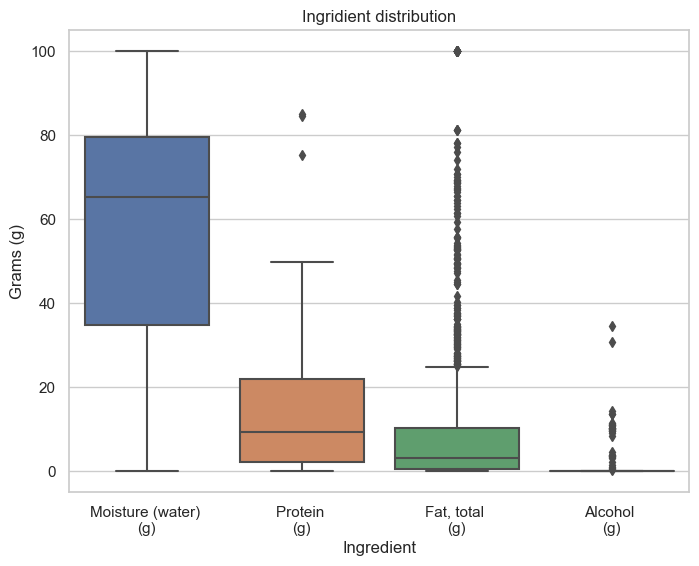

In [4]:
#Create boxplot for ingredients
plt.figure(figsize=(8,6),dpi=100)
sns.boxplot(data=df[["Moisture (water) \n(g)", "Protein \n(g)", "Fat, total \n(g)", "Alcohol \n(g)"]])
#Label the figure
plt.ylabel('Grams (g)');
plt.xlabel('Ingredient');
plt.title('Ingridient distribution');

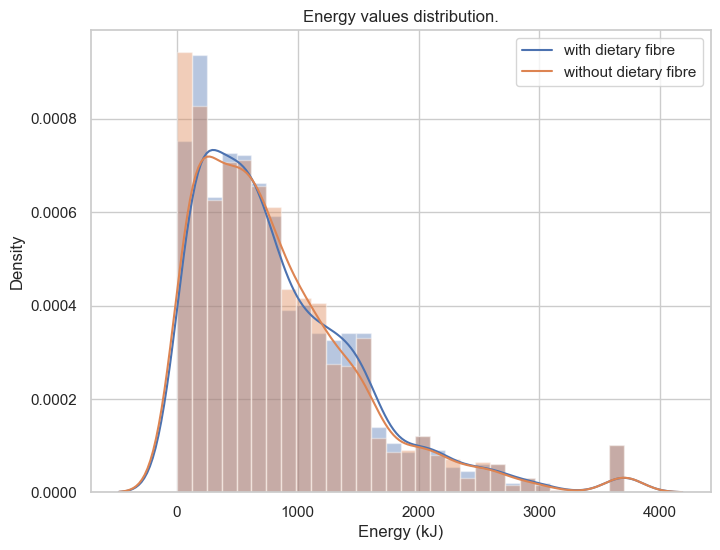

In [5]:
#Create a PDF of energy in the food items
plt.figure(figsize=(8,6),dpi=100)
sns.distplot(df['Energy with dietary fibre, equated \n(kJ)'], bins=30);
sns.distplot(df['Energy, without dietary fibre, equated \n(kJ)'], bins=30);
#Label the plot
plt.legend(["with dietary fibre", "without dietary fibre"])
plt.xlabel("Energy (kJ)");
plt.title("Energy values distribution.");

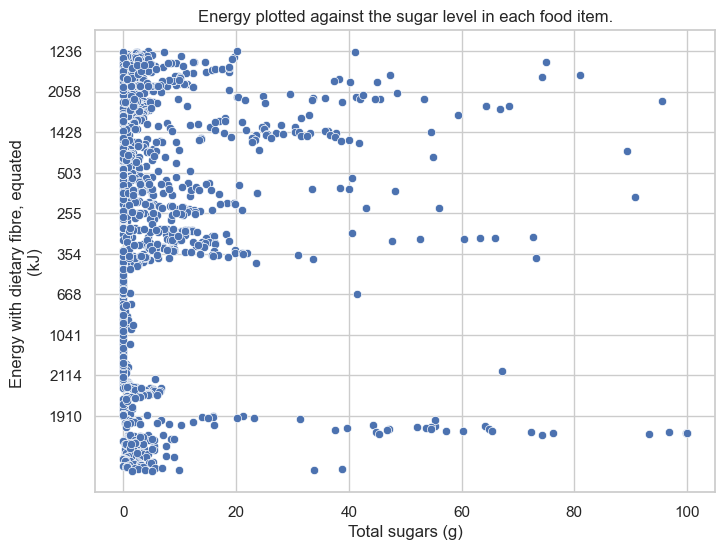

In [6]:
#Create a scatter plot to show correlation between columns
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.scatterplot(x=df['Total sugars (g)'], y=df['Energy with dietary fibre, equated \n(kJ)'],ax=ax)
#Setup and label the plot axis
start = int(min(df['Energy with dietary fibre, equated \n(kJ)']))
end = int(max(df['Energy with dietary fibre, equated \n(kJ)']))
ax.yaxis.set_ticks(np.arange(start, end, 100));
plt.title("Energy plotted against the sugar level in each food item.");

# Data Pre-processing
## Cleaning

In [3]:
#Remove unwanted columns
df.drop(["Public Food Key", "Food Name"], axis=1, inplace=True)
#Print column names with missing entries
print(df.columns[df.isnull().any()])
#Replace missing values with mean
df['Classification'].fillna(value=df['Classification'].mean(), inplace=True)
df['Fructose \n(g)'].fillna(value=df['Fructose \n(g)'].mean(), inplace=True)
df['Glucose \n(g)'].fillna(value=df['Glucose \n(g)'].mean(), inplace=True)
df['Sucrose\n(g)'].fillna(value=df['Sucrose\n(g)'].mean(), inplace=True)
df['Maltose \n(g)'].fillna(value=df['Maltose \n(g)'].mean(), inplace=True)
df['Lactose \n(g)'].fillna(value=df['Lactose \n(g)'].mean(), inplace=True)

Index(['Classification', 'Fructose \n(g)', 'Glucose \n(g)', 'Sucrose\n(g)',
       'Maltose \n(g)', 'Lactose \n(g)'],
      dtype='object')


## Normalization

In [4]:
#Standard Scaler
scaler = StandardScaler()
#Get Column names from the data
col_names = df.columns
#Scale the dataset
features = scaler.fit_transform(df)
#Store the scaled dataset in dataframe
df = pd.DataFrame(features, columns = col_names)
#Create a copy of the dataframe
df_reg = df.copy()

## Principal Component Analysis

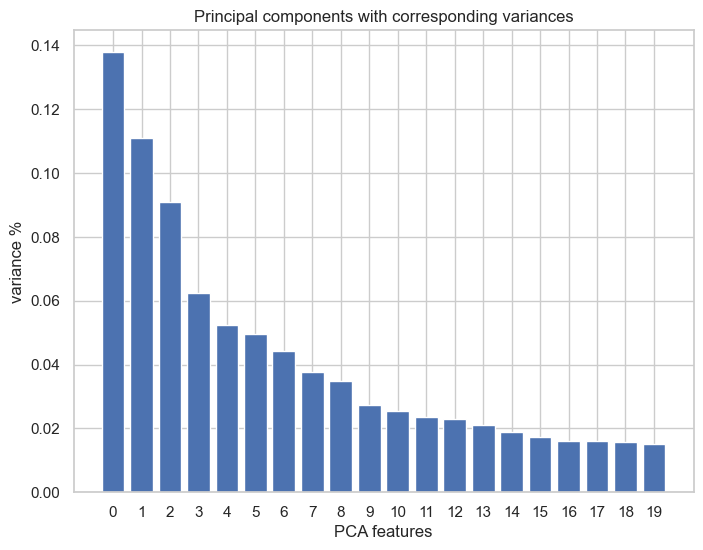

In [9]:
#Perform PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(df)
#Create a dataframe of the features
PCA_components = pd.DataFrame(principalComponents)

#Plotting the features variance
plt.figure(figsize=(8,6), dpi=100)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_);
#Label the plot
plt.xlabel('PCA features');
plt.ylabel('variance %');
plt.xticks(features);
plt.title("Principal components with corresponding variances");

# K-means Clustering
## Elbow method

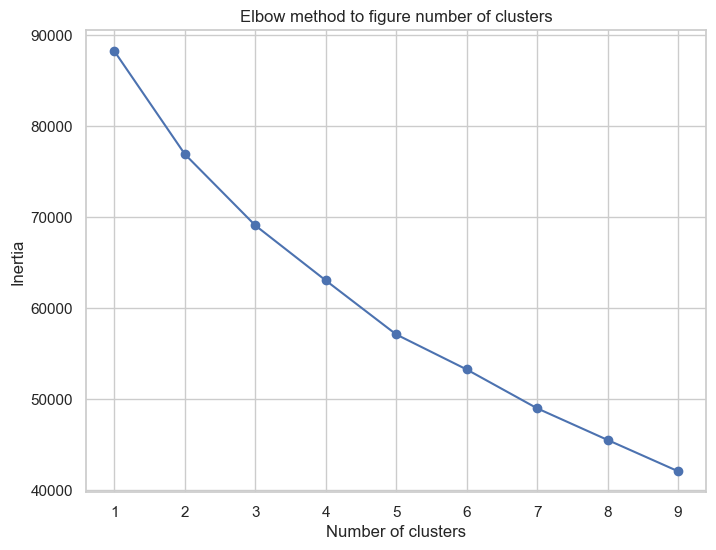

In [10]:
#Variable to store the inertia values for each k
SSE = []
#Iterating over different k values
for cluster in range(1,10):
    #Fitting the k means algorithm
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(PCA_components)
    #Calculating and storing the inertia
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(8,6), dpi=100)
plt.plot(frame['Cluster'], frame['SSE'], marker='o');
plt.xlabel('Number of clusters');
plt.ylabel('Inertia');
plt.title("Elbow method to figure number of clusters");

## Model training and prediction

In [11]:
#Number of clusters
n_clusters = 2
#Create k-means model
k_model = KMeans(n_clusters=n_clusters)
#Model training and prediction
clusters = k_model.fit_predict(PCA_components)
#Adding cluster column to data
df["cluster_pred"] = clusters

## Silhouette Analysis

For n_clusters = 2 The average silhouette_score is : 0.2547765864592619


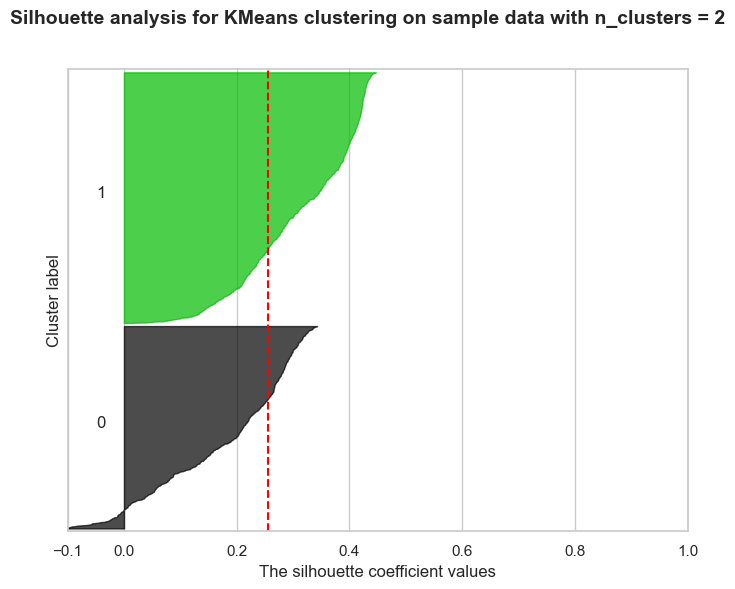

In [12]:
#Create figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
# The silhouette coefficient can range from -1, 1
ax.set_xlim([-0.1, 0.5])                           #X-axis limit
ax.set_ylim([0, len(df) + (n_clusters + 1) * 10])  #Y-axis limit
# Compute the silhouette score
sample_silhouette_values = silhouette_samples(PCA_components, k_model.labels_)
# Compute the average silhouette score
silhouette_avg = silhouette_score(PCA_components, k_model.labels_)
y_lower = 10
#For loop over respective cluster
for i in range(n_clusters):
  # Aggregate the silhouette scores
  ith_cluster_silhouette_values = \
      sample_silhouette_values[k_model.labels_ == i]
  ith_cluster_silhouette_values.sort() #Sorting each cluster score
  #Setting limit for each cluster in y-axis
  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i
  #Setting color for each cluster's silhouette coefficients
  color = cm.nipy_spectral(float(i) / n_clusters) 
  ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
  # Label the silhouette plots with their cluster numbers at the middle
  ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

#Label the plot properly
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold');
#Printing the average silhouette score for the clusters
print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

## Clusters

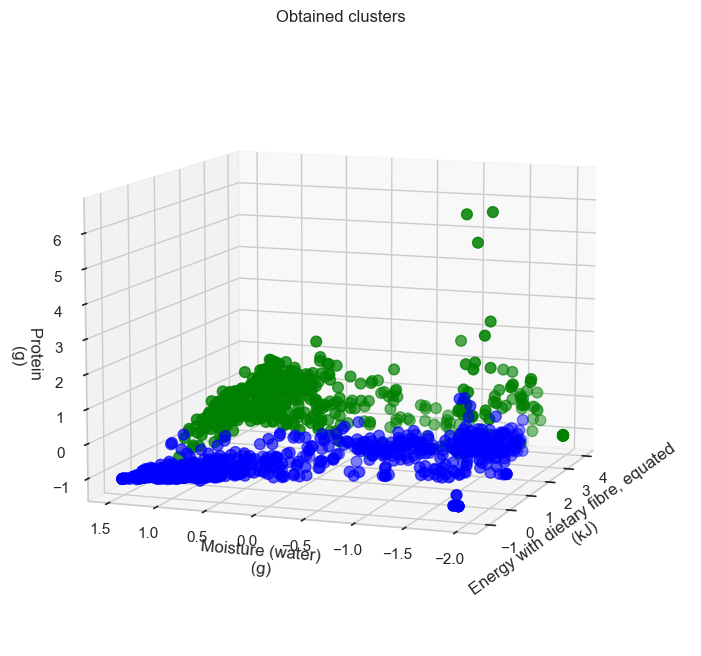

In [13]:
#Features to plot
ft1 = "Energy with dietary fibre, equated \n(kJ)"
ft2 = "Moisture (water) \n(g)"
ft3 = "Protein \n(g)"

#Plotting the clusters
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[ft1][df.cluster_pred == 0], df[ft2][df.cluster_pred == 0], df[ft3][df.cluster_pred == 0], c='green', s=60)
ax.scatter(df[ft1][df.cluster_pred == 1], df[ft2][df.cluster_pred == 1], df[ft3][df.cluster_pred == 1], c='blue', s=60)
#Set and label the plot
ax.view_init(10, 200)
ax.set_xlabel(ft1);
ax.set_ylabel(ft2);
ax.set_zlabel(ft3);
ax.set_title("Obtained clusters");

# XGBoost
## Training

In [14]:
#Create features and labels
X=df_reg.drop(['Energy with dietary fibre, equated \n(kJ)',
               'Energy, without dietary fibre, equated \n(kJ)'], axis=1)
Y=df_reg['Energy with dietary fibre, equated \n(kJ)']

#Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#Create model
xgb_model = XGBRegressor()



#Train the model with training data
xgb_model.fit(x_train, y_train);

## Evaluation

Model mean squared error on the test data:  0.005021570844054533
Model mean absolute error on the test data:  0.04230943636385513


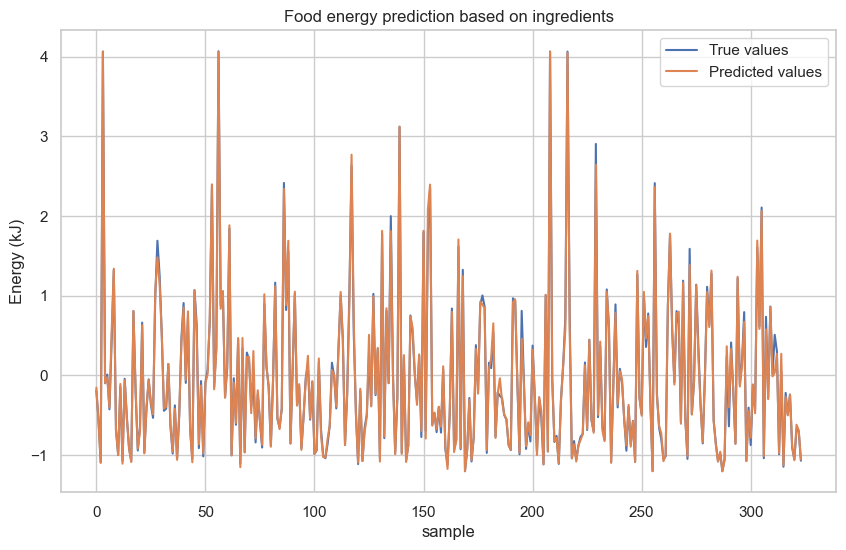

In [16]:
#Make predictions for the test data
xgb_pred = xgb_model.predict(x_test)
#Calculate MSE and MAE score
mae = mean_absolute_error(y_test, xgb_pred)
mse = mean_squared_error(y_test, xgb_pred)
#Print the values
print("Model mean squared error on the test data: ", mse)
print("Model mean absolute error on the test data: ", mae)

#Plot model prediction
plt.figure(figsize=(10,6),dpi=100)
sns.set_theme(style='whitegrid')
plt.plot(range(len(y_test)),y_test);
plt.plot(range(len(xgb_pred)),xgb_pred);
#Label the plot
plt.xlabel('sample');
plt.ylabel('Energy (kJ)');
plt.title("Food energy prediction based on ingredients");
plt.legend(["True values", "Predicted values"]);